<a href="https://colab.research.google.com/github/manuelP88/text_classification/blob/main/newspaper_vs_propaganda_text_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install datasets
!pip install transformers
!pip install torch

     |████████████████████████████████| 290 kB 5.7 MB/s 
     |████████████████████████████████| 132 kB 42.6 MB/s 
     |████████████████████████████████| 243 kB 36.1 MB/s 
     |████████████████████████████████| 59 kB 4.0 MB/s 
     |████████████████████████████████| 1.1 MB 30.8 MB/s 
     |████████████████████████████████| 192 kB 45.2 MB/s 
     |████████████████████████████████| 271 kB 39.6 MB/s 
     |████████████████████████████████| 160 kB 45.4 MB/s 
     |████████████████████████████████| 3.1 MB 5.4 MB/s 
     |████████████████████████████████| 3.3 MB 35.0 MB/s 
     |████████████████████████████████| 596 kB 36.3 MB/s 
     |████████████████████████████████| 895 kB 27.3 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [2]:
import warnings

from datasets import load_dataset, DatasetDict
import pandas as pd
import torch
import torch.utils.data as torch_data
from transformers import DistilBertModel, DistilBertTokenizer, AdamW, DistilBertForSequenceClassification
from datasets import load_metric
import transformers.modeling_outputs
from transformers import get_scheduler

from torch import cuda
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

import types

In [3]:
def require_not_None(obj, message="Require not None") -> object:
    if obj is None:
        raise Exception(message)
    return obj

def load_dataset_from_csv_enc_labels(csv_path=None) -> pd.DataFrame:
    require_not_None(csv_path)
    # Import the csv into pandas dataframe and add the headers
    df = pd.read_csv(
        csv_path,
        sep='§',
        #names=['url', 'domain', 'label', 'title', 'text'],
        engine='python'
    )
    df = df[['domain', 'text', 'label']]

    encode_dict = {}

    def encode_cat(x):
        if x not in encode_dict.keys():
            encode_dict[x] = len(encode_dict)
        return encode_dict[x]

    df['enc_label'] = df['label'].apply(lambda x: encode_cat(x))
    if len(encode_dict.keys()) != 2: raise Exception("error! More tan 2 categories are detected!")
    return df

In [4]:
def train_test_split(train:pd.DataFrame, frac: float = 0.8, random_state:int=200):
    require_not_None(train)
    require_not_None(frac)

    train_dataset = train.sample(frac=frac, random_state=random_state)
    test_dataset = train.drop(train_dataset.index).reset_index(drop=True)
    train_dataset = train_dataset.reset_index(drop=True)


    return train_dataset, test_dataset

In [5]:
batch_size = 16
LEARNING_RATE = 1e-05
num_epochs = 20

In [6]:
from google.colab import drive
drive.mount('/drive')

ds2 = '/drive/My Drive/Colab Notebooks/datasets/newspaper_vs_propaganda.csv'
model_out = '/drive/My Drive/Colab Notebooks/models/newspaper_vs_propaganda_model'


df = load_dataset_from_csv_enc_labels( ds2 )  

Mounted at /drive


In [7]:
df.label.value_counts()

newspaper     14905
propaganda      782
Name: label, dtype: int64

In [8]:
def downsample(df:pd.DataFrame, label_col_name:str, random_state:int=200) -> pd.DataFrame:
    # find the number of observations in the smallest group
    nmin = df[label_col_name].value_counts().min()
    return (df
            # split the dataframe per group
            .groupby(label_col_name)
            # sample nmin observations from each group
            .apply(lambda x: x.sample(nmin, random_state=random_state))
            # recombine the dataframes
            .reset_index(drop=True)
            )

In [9]:
df = downsample(df, "label")
df.label.value_counts()

propaganda    782
newspaper     782
Name: label, dtype: int64

In [10]:
train_dataset, test_dataset = train_test_split(df, frac=0.2)#0,8
train_dataset, val_dataset = train_test_split(train_dataset, frac=0.8)
warnings.warn("What are the right dimensions of train-validation-test sets?")

print("FULL Dataset: {}".format(df.shape))
print("TRAIN Dataset: {}".format(train_dataset.shape))
print("TEST Dataset: {}".format(test_dataset.shape))
print("VALID Dataset: {}".format(val_dataset.shape)) 

FULL Dataset: (1564, 4)
TRAIN Dataset: (250, 4)
TEST Dataset: (1251, 4)
VALID Dataset: (63, 4)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: What are the right dimensions of train-validation-test sets?
  This is separate from the ipykernel package so we can avoid doing imports until


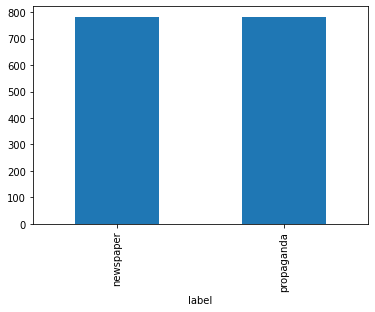

In [11]:
df.groupby("label")["label"].count().plot(kind='bar')

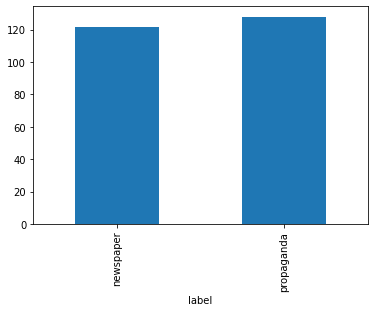

In [12]:
train_dataset.groupby("label")["label"].count().plot(kind='bar')

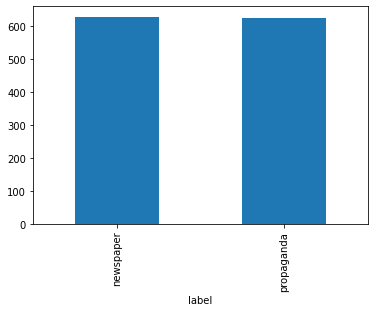

In [13]:
test_dataset.groupby("label")["label"].count().plot(kind='bar')

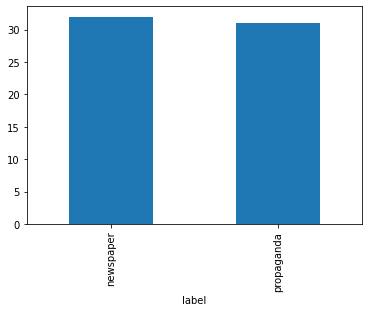

In [14]:
val_dataset.groupby("label")["label"].count().plot(kind='bar')

In [15]:
class GossipScience(torch_data.Dataset):

    def __init__(self, dataframe, tokenizer, max_len=512):
        self.len = len(dataframe)
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_len = max_len

    def _get_value(self, index):
        text = str(self.data.text[index])
        text = " ".join(text.split())
        return text

    def __getitem__(self, index):
        value = self._get_value(index)

        inputs = self.tokenizer.encode_plus(
            value, add_special_tokens=True,
            max_length=self.max_len, truncation=True,
            padding="max_length"
        )
        return {
            'input_ids': torch.tensor(inputs['input_ids'], dtype=torch.long),
            'attention_mask': torch.tensor(inputs['attention_mask'], dtype=torch.long),
            'labels': torch.tensor(self.data.enc_label[index], dtype=torch.long)
        }

    def get_my_item(self, index):
      return self.__getitem__(index)

    def __len__(self):
        return self.len


In [16]:
checkpoint = 'distilbert-base-cased'
tokenizer = DistilBertTokenizer.from_pretrained( checkpoint )
training_set = GossipScience(train_dataset, tokenizer)
testing_set = GossipScience(test_dataset, tokenizer)
validation_set = GossipScience(val_dataset, tokenizer)

train_params = {'batch_size': batch_size, 'shuffle': True}
test_params = {'batch_size': batch_size, 'shuffle': True}
validation_params = {'batch_size': batch_size, 'shuffle': True}

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
training_loader:torch_data.DataLoader = torch_data.DataLoader(training_set, **train_params)
test_loader:torch_data.DataLoader = torch_data.DataLoader(testing_set, **test_params)
validation_loader:torch_data.DataLoader = torch_data.DataLoader(validation_set, **validation_params)

model = DistilBertForSequenceClassification.from_pretrained( checkpoint )

warnings.warn("You have to train a more complex model!")


Downloading:   0%|          | 0.00/208k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/426k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/411 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/251M [00:00<?, ?B/s]

Some weights of the model checkpoint at distilbert-base-cased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['pre_classifier.weight', 'classifier.weight', 'pre_classifi

In [17]:
import torch
torch.cuda.is_available()

True

In [18]:
training_loader

In [19]:
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE)

num_training_steps = num_epochs * len(training_loader)
progress_bar = tqdm(range(num_training_steps))
lr_scheduler = get_scheduler(
        "linear",
        optimizer=optimizer,
        num_warmup_steps=0,
        num_training_steps=num_training_steps
    )

loss_fct = torch.nn.CrossEntropyLoss()

model.to(device)
 
accuracies:dict = {}
avg_training_loss: dict = {}
avg_validation_loss: dict = {}
validation_accuracy: dict = {}

for epoch in range(num_epochs):
  accuracies[epoch] = []
  training_loss = 0.0
  valid_loss = 0.0

  tr_accuracy = load_metric("accuracy")

  model.train()
  count=0
  for batch in training_loader:
    optimizer.zero_grad()
    batch = {k: v.to(device) for k, v in batch.items()}
    outputs = model(**batch)
    loss = loss_fct(outputs.get('logits'), batch.get("labels"))

    predictions = torch.argmax(outputs.get('logits'), dim=-1)
    tr_accuracy.add_batch(predictions=predictions, references=batch["labels"])
    accuracies[epoch].append( tr_accuracy.compute()['accuracy'] )
    
    loss.backward()
    optimizer.step()
    training_loss+=loss.data.item()
    lr_scheduler.step()
    progress_bar.update(1)

    count=count+1
  
  training_loss/=len(training_loader)
  avg_training_loss[epoch] = training_loss
    
  accuracy = load_metric("accuracy")
    
  model.eval()
  for batch in validation_loader:
    batch = {k: v.to(device) for k, v in batch.items()}
    with torch.no_grad():
      outputs = model(**batch)
        
    loss = loss_fct(outputs.get('logits'), batch.get("labels"))
    valid_loss+=loss.data.item()
    predictions = torch.argmax(outputs.get('logits'), dim=-1)
    accuracy.add_batch(predictions=predictions, references=batch["labels"])
  
  valid_loss/=len(validation_loader)
  avg_validation_loss[epoch] = valid_loss
  validation_accuracy[epoch] = accuracy.compute()['accuracy']

  print("Epoch: "+str(epoch)+", Training Loss: "+str(avg_training_loss[epoch])+", Validation Loss: "+str(avg_validation_loss[epoch])+", accuracy = "+str(validation_accuracy[epoch]))

  0%|          | 0/320 [00:00<?, ?it/s]

Downloading:   0%|          | 0.00/1.42k [00:00<?, ?B/s]

Epoch: 0, Training Loss: 0.6861464902758598, Validation Loss: 0.6680929213762283, accuracy = 0.7777777777777778
Epoch: 1, Training Loss: 0.6355004347860813, Validation Loss: 0.5851230621337891, accuracy = 0.7777777777777778
Epoch: 2, Training Loss: 0.5369349587708712, Validation Loss: 0.4408029615879059, accuracy = 0.7936507936507936
Epoch: 3, Training Loss: 0.36574446596205235, Validation Loss: 0.24995044618844986, accuracy = 0.9365079365079365
Epoch: 4, Training Loss: 0.19719312712550163, Validation Loss: 0.1525615993887186, accuracy = 0.9682539682539683
Epoch: 5, Training Loss: 0.11702514183707535, Validation Loss: 0.14228953793644905, accuracy = 0.9523809523809523
Epoch: 6, Training Loss: 0.06459334003739059, Validation Loss: 0.14313083933666348, accuracy = 0.9523809523809523
Epoch: 7, Training Loss: 0.048064157483167946, Validation Loss: 0.08365949289873242, accuracy = 0.9841269841269841
Epoch: 8, Training Loss: 0.035911249346099794, Validation Loss: 0.050782179459929466, accuracy

In [20]:

def plot_multiple_line(points:list=None, xlabel:str=None, ylabel:str=None, title:str=None):
  plt.figure()
  x_axis:int = range(0, max( [len(i) for i in points] ))
  for i in range(len(points)):
    plt.plot(x_axis, [x for x in points[i]])
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.title(title) 

In [21]:
def plot_dict(d:dict=None, xlabel:str=None, ylabel:str=None, title:str=None):
  lists = sorted(d.items()) # sorted by key, return a list of tuples
  x, y = zip(*lists) # unpack a list of pairs into two tuples
  plt.plot(x, y)
  plt.xlabel(xlabel)
  plt.ylabel(ylabel)
  plt.title(title)

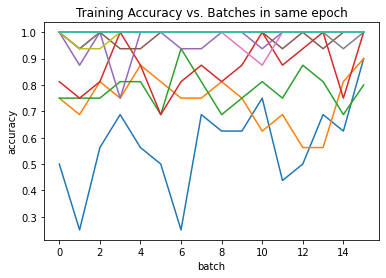

In [22]:
plot_multiple_line(list(accuracies.values()), 'batch', 'accuracy', 'Training Accuracy vs. Batches in same epoch')

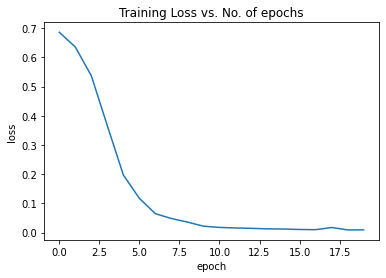

In [23]:
plot_dict(avg_training_loss, 'epoch', 'loss', 'Training Loss vs. No. of epochs')

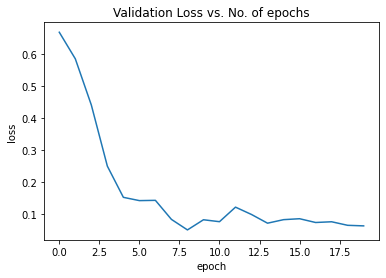

In [24]:
plot_dict(avg_validation_loss, 'epoch', 'loss', 'Validation Loss vs. No. of epochs')

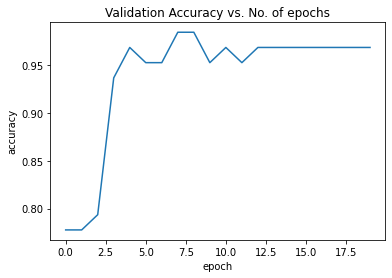

In [25]:
plot_dict(validation_accuracy, 'epoch', 'accuracy', 'Validation Accuracy vs. No. of epochs')

In [26]:
test_accuracy = load_metric("accuracy")
avg_test_loss = 0

model.eval()
for batch in test_loader:
  batch = {k: v.to(device) for k, v in batch.items()}
  with torch.no_grad():
    outputs = model(**batch)
        
  loss = loss_fct(outputs.get('logits'), batch.get("labels"))
  avg_test_loss+=loss.data.item()
  predictions = torch.argmax(outputs.get('logits'), dim=-1)
  test_accuracy.add_batch(predictions=predictions, references=batch["labels"])
  
avg_test_loss/=len(test_loader)

print("Test Loss: "+str(avg_test_loss)+", accuracy = "+str(test_accuracy.compute()['accuracy']))

Test Loss: 0.196153257272053, accuracy = 0.938449240607514


In [27]:
torch.save(model, model_out)